# State of Health Prediction using LSTM and RUL Estimation using Deterministic Model

Create SoH prediction using LSTM and RUL estimation using Linear Regression for smartphone battery degradation. This notebook include EDA, Feature Engineering, Data Processing, Model Building, and Evaluation.

## Data Preprocessing

### Data Extraction

Extract smartphone data from Supabase collected from smartphone application

In [150]:
# Import necessary modules
import os
import sys
from pathlib import Path

# Define current and root directory paths
CWD = Path().resolve()
ROOT = CWD.parents[0]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.utils.utils import connect_to_db
from dotenv import load_dotenv
load_dotenv(ROOT / ".env")

# Define database connection parameters
PORT = os.getenv("PORT")
USERNAME = os.getenv("USERNAME")
PASSWORD = os.getenv("PASSWORD")
HOST = os.getenv("HOST")
DATABASE = os.getenv("DATABASE")

# Check connection parameters
if not all([PORT, USERNAME, PASSWORD, HOST, DATABASE]):
    print("Error: One or more database connection parameters are missing.")
    sys.exit(1)

# Establish connection to the database
conn = connect_to_db(HOST, PORT, DATABASE, USERNAME, PASSWORD)

Connection to database established successfully.


### Data Convertion

Convert extracted data from Supabase into dataframe format, ensure all the columns matches the data type.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Extract data from the database
with conn.cursor() as cursor:
  cursor.execute("SELECT * FROM public.raw_metrics ORDER BY device_id, created_at ASC")
  data = cursor.fetchall()
  # Convert to DataFrame
  df = pd.DataFrame(data, columns=[desc[0] for desc in cursor.description])

# Ensure sorted data
df["created_at"] = pd.to_datetime(df["created_at"])
df = df.sort_values(["device_id", "created_at"]).reset_index(drop=True)

In [152]:
# Convert to Jakarta timezone
import pytz
df['created_at'] = df['created_at'].dt.tz_convert('Asia/Jakarta')
df['ts_utc'] = df['ts_utc'].dt.tz_convert('Asia/Jakarta')

# Check null values
df.isnull().sum()

# Drop unused columns
df.drop(["charge_source", "energy_nwh", "cycles_count", "current_avg_ua"], axis=1).head()

,id,user_id,device_id,ts_utc,net_type,channel_quality,rx_total_bytes,tx_total_bytes,batt_voltage_mv,batt_current_ua,batt_temp_c,is_charging,battery_health,battery_level,charge_counter_uah,battery_capacity_pct,fg_pkg,created_at
0,5f9a61dc-10af-462a-af07-00cc8e452677,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:26:10.349366+07:00,WiFi,-56,2014928638,112746489,3703,623000,35.5,False,GOOD,16.0,518000,16,Device Analytics,2025-11-10 20:26:11.940321+07:00
1,6057bf9c-b150-4ec8-8786-7d731bb7ec94,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:26:11.805850+07:00,WiFi,-56,2014928978,112747759,3703,623000,35.5,False,GOOD,16.0,518000,16,Device Analytics,2025-11-10 20:26:12.630878+07:00
2,d55733e0-af40-45b7-8380-d39ba4f92bec,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:29:59.093424+07:00,WiFi,-54,2045926067,114374859,3586,653000,36.1,False,GOOD,15.0,488000,15,Instagram,2025-11-10 20:30:00.489796+07:00
3,f178b802-d1d3-4280-b371-a4460cccdeed,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:53:21.834407+07:00,WiFi,-59,2055732576,115764715,3467,1524000,32.5,False,GOOD,14.0,437000,14,Device Analytics,2025-11-10 20:53:22.714987+07:00
4,75c65cc2-7db9-4d2e-aab7-9a0caced7ce5,None,22021211RG-0940e2943d7b49eb,2025-11-10 21:09:33.882115+07:00,WiFi,-60,2062366807,117028496,4305,-4525000,36.0,True,GOOD,20.0,612000,20,Discord,2025-11-10 21:09:34.698560+07:00


In [153]:
# Count device IDs rows
df['device_id'].value_counts()

device_id
SM-S931B-57bc0e2d9eac7750            1462
2311DRK48G-b135dcd1d7e9320f          1067
SM-A155F-7d69b63bc200801a             982
SM-A336E-c471046323c8859c             882
SM-S926B-1ccc6862dc88e6b9             843
2312DRA50G-223024e791e6150d           839
22021211RG-0940e2943d7b49eb           775
SM-A546E-701861f29b4d5913             741
SM-S911B-aee10fcb8586030e             723
SM-A356E-4e32dd36015962aa             719
SM-A546E-1cf82eec40a3542b             711
2406APNFAG-4b17a6ddf26cd705           711
SM-A336E-c89e0bb491fe3651             683
SM-A725F-6698366a2e3a4ff1             680
SM-S921B-d2c3f5675ad3a14d             642
Infinix X669C-a1b2d29d54d19af3        553
SM-S916B-205d95c2abec51c0             364
SM-A556E-7ecd175336df7fc4             210
24117RN76O-af9a140a5e0ea0de           207
SM-A556E-5f0400c50aae82ca             204
SM-A256E-7e0aca17c219854b              88
SM-T505-280eb41faa621df0               85
SM-A546E-8af17d67f9288898              74
Redmi Note 9 Pro-d2c7435

### Histogram Plot

Plot the data columns as histogram plot to extract the insights

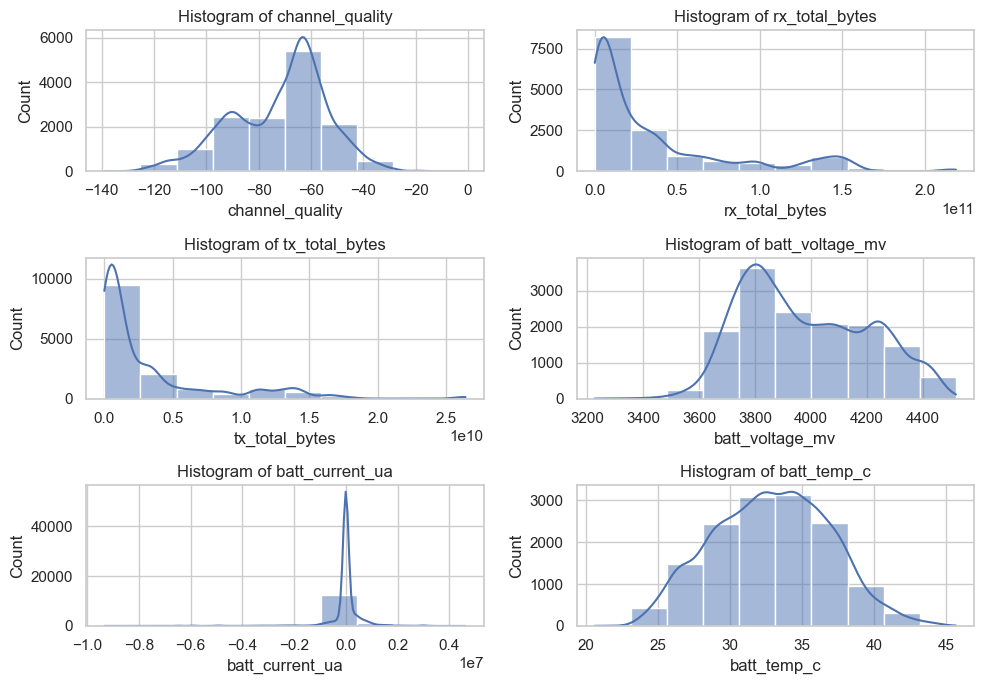

In [154]:
import seaborn as sns

plt.rcParams['agg.path.chunksize'] = 20000

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 7))

# List of numerical columns
numerical_cols = ['channel_quality', 'rx_total_bytes', 'tx_total_bytes', 'batt_voltage_mv',
'batt_current_ua', 'batt_temp_c', "charge_counter", "battery_capacity_pct"]

# Plot histograms for each numerical column
for ax, col in zip(axes.flatten(), numerical_cols):
    sns.histplot(df[col], bins=10, kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

### Throughput and Energy Calculation

Calculate throughput and energy over time from smartphone data collected from Supabase

In [155]:
# Ensure 'created_at' is in datetime format
df["created_at"] = pd.to_datetime(df["created_at"])

# Calculate time difference in seconds
df["delta_t"] = df["created_at"].diff().dt.total_seconds().fillna(0)

# Convert voltage from mV to V and current from uA to A
df["batt_voltage_v"] = df["batt_voltage_mv"] / 1000
df["batt_current_a"] = df["current_avg_ua"] / 1_000_000

# Energi per step (Joule)
df["energy_over_time"] = df["batt_voltage_v"] * df["batt_current_a"] * df["delta_t"]
df["energy_over_time"] = df["energy_over_time"] / 3600

# Calculate throughput
df = df.sort_values("ts_utc")
df["delta_t"] = df["ts_utc"].diff().dt.total_seconds()
df["delta_tx"] = df["tx_total_bytes"].diff()
df["delta_rx"] = df["rx_total_bytes"].diff()

df["throughput_total_bps"] = (df["delta_tx"] + df["delta_rx"]) * 8 / df["delta_t"]

# Drop NaN values
df.loc[df["delta_t"] <= 0, "throughput_total_bps"] = np.nan
df["throughput_total_bps"].replace([np.inf, -np.inf], np.nan, inplace=True)

df["throughput_total_mbps"] = df["throughput_total_bps"] / 1e6

C:\Users\Fadel\AppData\Local\Temp\ipykernel_7564\2251008585.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["throughput_total_bps"].replace([np.inf, -np.inf], np.nan, inplace=True)


### Calculate Energy per Bit

Calculate energy per bit using Throughput metrics. The equation derived from *Energy Model for Data Transfer* paper, alpha and beta values used from paper. 

In [156]:
# Replace zero throughput with NaN to avoid division by zero
df["throughput_total_bps"] = df["throughput_total_bps"].replace(0, np.nan)

# Cofficient from paper
alpha_tx = 446.2936  # nJ/bit
beta_tx = 3.381132   # nJ/bit
alpha_rx = 357.5443  # nJ/bit
beta_rx = 1.969068   # nJ/bit

# Energy per bit calculation
df["energy_per_bit_tx"] = (alpha_tx / df["throughput_total_bps"]) + beta_tx
df["energy_per_bit_rx"] = (alpha_rx / df["throughput_total_bps"]) + beta_rx
df["energy_per_bit_tx_J"] = df["energy_per_bit_tx"] * 1e-9
df["energy_per_bit_rx_J"] = df["energy_per_bit_rx"] * 1e-9

# Energy per bit total calculation
df["energy_per_bit_avg_J"] = (df["energy_per_bit_tx_J"] + df["energy_per_bit_rx_J"]) / 2

# Preview result
df[[
  "ts_utc",
  "throughput_total_bps",
  "energy_per_bit_tx_J",
  "energy_per_bit_rx_J",
  "energy_per_bit_avg_J",
]].head()

,ts_utc,throughput_total_bps,energy_per_bit_tx_J,energy_per_bit_rx_J,energy_per_bit_avg_J
12784,2025-10-31 05:38:28.628023+07:00,NaN,NaN,NaN,NaN
12785,2025-10-31 05:53:30.429297+07:00,1.313596e+06,3.381472e-09,1.969340e-09,2.675406e-09
12786,2025-10-31 06:08:32.072450+07:00,3.407266e+06,3.381263e-09,1.969173e-09,2.675218e-09
12787,2025-10-31 06:23:33.918787+07:00,4.534018e+06,3.381230e-09,1.969147e-09,2.675189e-09
12788,2025-10-31 06:38:35.969953+07:00,5.097230e+06,3.381220e-09,1.969138e-09,2.675179e-09


Calculate battery cost of traffic using average voltage and energy per bit

In [157]:
# Average voltage
V_avg = df["batt_voltage_v"].mean()

# Calculate Battery Cost of Traffic (BoT)
# BoT = (E_b * (8 × 10^9) / V_avg) × (1000 / 3600)
df["BoT_mAh_per_Gbps"] = (df["energy_per_bit_avg_J"] * (8 * 1e9) / V_avg) * (1000 / 3600)

# Preview result
df[["ts_utc", "throughput_total_bps", "energy_per_bit_avg_J", "BoT_mAh_per_Gbps"]].head()

,ts_utc,throughput_total_bps,energy_per_bit_avg_J,BoT_mAh_per_Gbps
12784,2025-10-31 05:38:28.628023+07:00,NaN,NaN,NaN
12785,2025-10-31 05:53:30.429297+07:00,1.313596e+06,2.675406e-09,1.494229
12786,2025-10-31 06:08:32.072450+07:00,3.407266e+06,2.675218e-09,1.494124
12787,2025-10-31 06:23:33.918787+07:00,4.534018e+06,2.675189e-09,1.494108
12788,2025-10-31 06:38:35.969953+07:00,5.097230e+06,2.675179e-09,1.494102


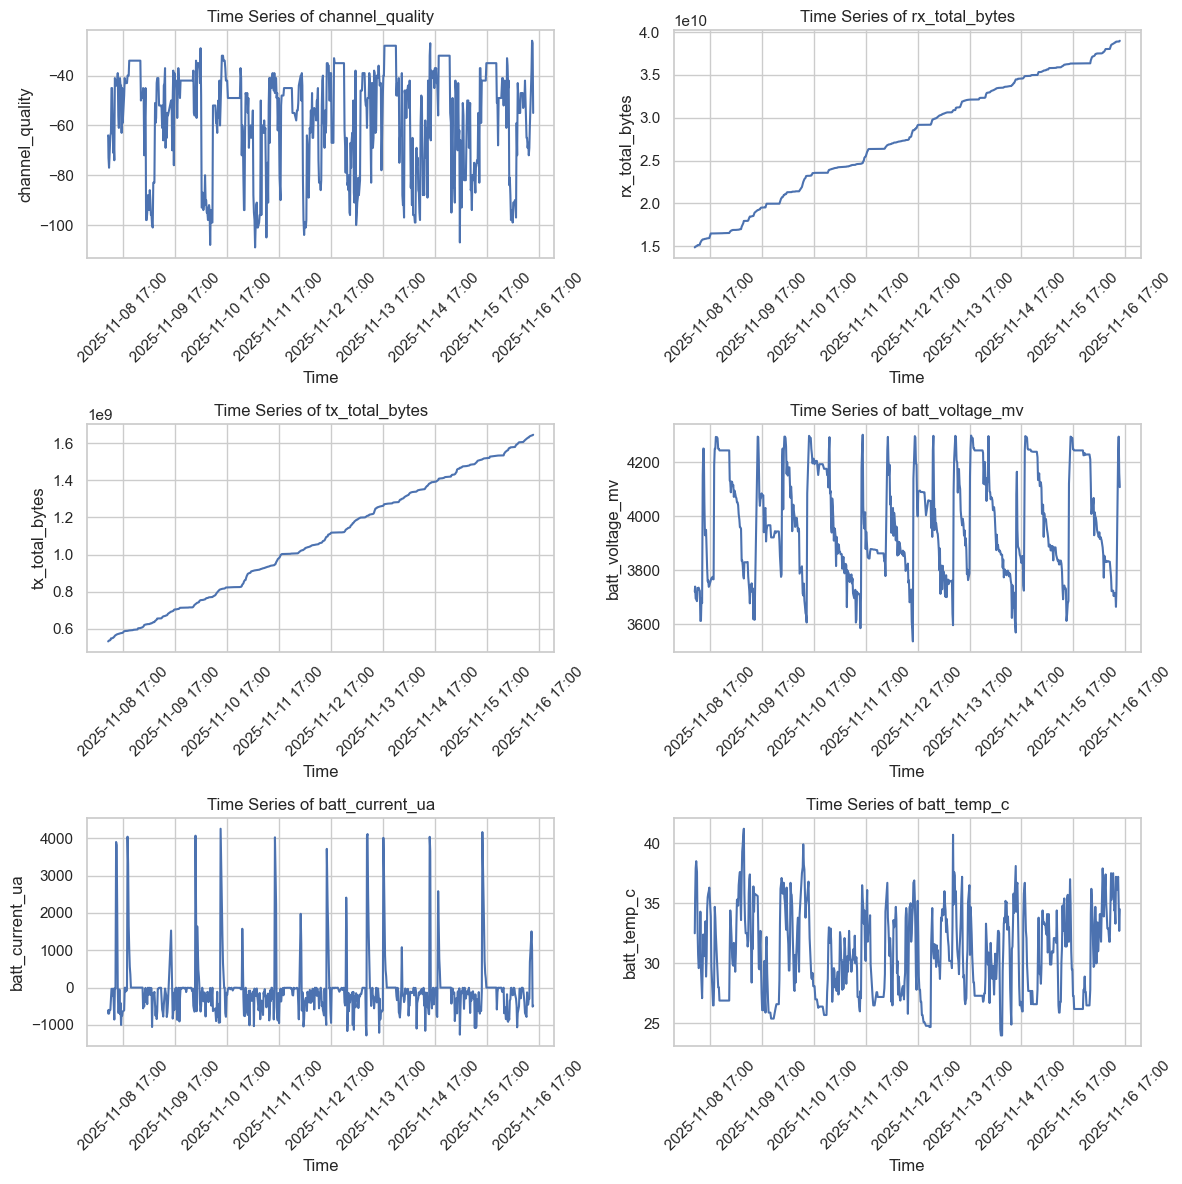

In [158]:
import matplotlib.dates as mdates

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

df_sm = df[df["device_id"] == "SM-A725F-6698366a2e3a4ff1"]

# Plot line charts for each numerical column
for ax, col in zip(axes.flatten(), numerical_cols):
    ax.plot(df_sm['created_at'], df_sm[col])
    ax.set_title(f'Time Series of {col}')
    ax.set_xlabel('Time')
    ax.set_ylabel(col)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

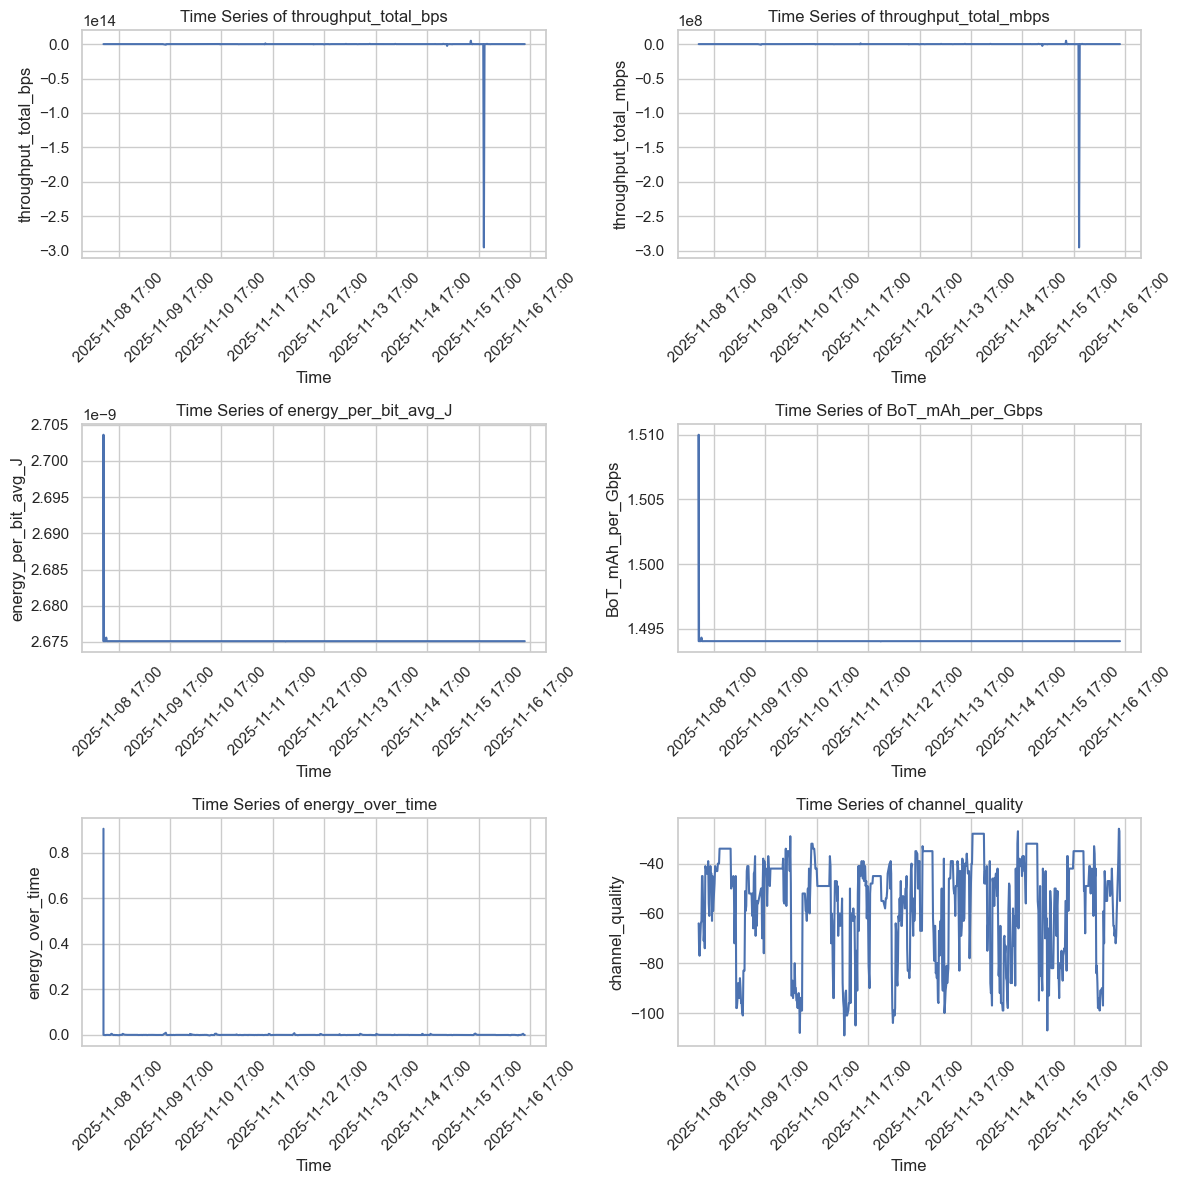

In [159]:
import matplotlib.dates as mdates

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

network_cols = [
  'throughput_total_bps',
  'throughput_total_mbps',
  'energy_per_bit_avg_J',
  'BoT_mAh_per_Gbps',
  "energy_over_time",
  "channel_quality"
]

df_sm = df[df["device_id"] == "SM-A725F-6698366a2e3a4ff1"]

# Plot line charts for each numerical column
for ax, col in zip(axes.flatten(), network_cols):
    ax.plot(df_sm['created_at'], df_sm[col])
    ax.set_title(f'Time Series of {col}')
    ax.set_xlabel('Time')
    ax.set_ylabel(col)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

## Application Usage Analysis

Create bar plot to see most usage application for every devices collected from smartphone battery application.

C:\Users\Fadel\AppData\Local\Temp\ipykernel_7564\113029621.py:11: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  plt.tight_layout()
c:\College\Bachelor\smartphone-battery-be\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


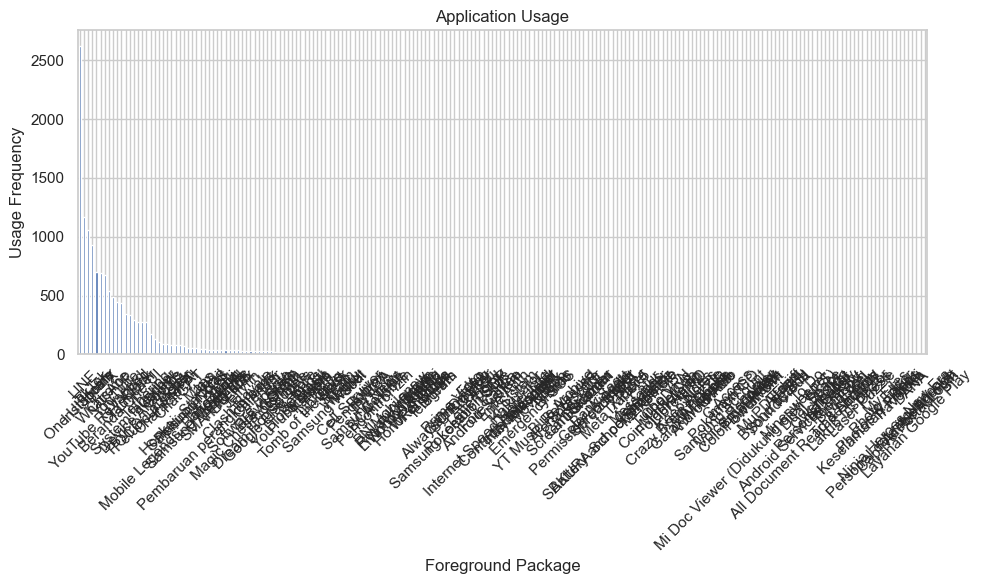

In [160]:
# Count the occurrences of each package
package_counts = df['fg_pkg'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
package_counts.plot(kind='bar')
plt.title('Application Usage')
plt.xlabel('Foreground Package')
plt.ylabel('Usage Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Detect infinix devices

In [161]:
# Detect all Infinix devices in df_all
infinix_devices = sorted([
  d for d in df["device_id"].unique()
  if "Infinix" in str(d)
])
print("Infinix devices detected:", infinix_devices)


Infinix devices detected: ['Infinix X669C-a1b2d29d54d19af3', 'Infinix X6886-e495e4491a5c2a82']


## Model Building

Create LSTM model to predict smartphone battery State of Health.

In [162]:
import os
import random
import numpy as np
import tensorflow as tf

# Set random seeds for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [163]:
df = df[~df["device_id"].isin(infinix_devices)].copy()
print("Remaining devices:", df["device_id"].nunique())

Remaining devices: 24


### Calculate State of Health and Battery Cycles

Create function to calculate state of health and battery cycles for LSTM prediction

In [164]:
from src.utils.utils import calculate_soh_and_cycles

# Merge device
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df = df.dropna(subset=["created_at"])
df = df.sort_values(["device_id", "created_at"]).reset_index(drop=True)


# Merge SoH calculation for all devices
df_all = (
  df
  .groupby("device_id", group_keys=False)
  .apply(lambda g: calculate_soh_and_cycles(g))
)

df_all["SoH_filled"] = df_all["SoH_smooth"].where(
  df_all["SoH_smooth"].notna(), df_all["SoH"]
)

df_all["SoH_filled"] = (
  df_all.groupby("device_id")["SoH_filled"]
    .transform(lambda s: s.ffill().bfill())
)

C:\Users\Fadel\AppData\Local\Temp\ipykernel_7564\2633615927.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: calculate_soh_and_cycles(g))


### Device Summary

Create device summary to check minimum and maximum State of Health values

In [165]:
# Device summary
summary = (df_all.groupby("device_id")["SoH_filled"].agg(["count","min","max"]).sort_values("max", ascending=False))
summary

,count,min,max
device_id,,,
SM-S931B-57bc0e2d9eac7750,1462,1.095238,1.095238
24117RN76O-af9a140a5e0ea0de,207,0.796485,1.095238
SM-A256E-7e0aca17c219854b,88,0.310274,1.000000
2406APNFAG-4b17a6ddf26cd705,711,0.736842,0.736842
2311DRK48G-b135dcd1d7e9320f,1067,0.736842,0.736842
SM-A336E-c471046323c8859c,882,0.736842,0.736842
SM-A155F-7d69b63bc200801a,982,0.736842,0.736842
SM-A356E-4e32dd36015962aa,719,0.736842,0.736842
SM-A546E-1cf82eec40a3542b,711,0.736842,0.736842


### Quarantine Devices

Exclude devices that had incomplete State of Health data

In [166]:
from src.utils.utils import quarantine_device

bad_devices = quarantine_device(df_all)
print("Bad devices:", bad_devices)

Bad devices: ['22021211RG-0940e2943d7b49eb', '23124RA7EO-3eb11a599d8b922d', '2312DRA50G-223024e791e6150d', 'Redmi Note 9 Pro-d2c7435268ff2367', 'SM-A256E-7e0aca17c219854b', 'SM-T505-280eb41faa621df0']


Sanity check to ensure the State of Health between 0 - 1.2

In [167]:
# Sanity checks
print("Devices:", df_all["device_id"].nunique(), "Rows:", len(df_all))
assert (df_all["SoH_filled"].dropna().between(0, 1.2)).all()

# EFC per devices
ok = df_all.groupby("device_id")["EFC"].apply(lambda s: (s.diff().fillna(0) >= -1e-9).all())
print("EFC monotonic all devices:", ok.all())

Devices: 24 Rows: 13749
EFC monotonic all devices: True


### Feature Processing

Create Z-Score normalization, also define target and feature columns

In [168]:
from src.utils.utils import add_aging_features

# Define base columns for aging features
AGING_BASE_COLS = [
  "batt_voltage_v",
  "batt_temp_c",
  "throughput_total_mbps",
  "energy_per_bit_avg_J",
  "SoH_filled",
  "EFC",
  "soh_trend",
  "efc_delta",
  "temp_ema",
  "temp_max_win",
  "tp_ema",
  "epb_ema",
]

# Function to add per-device z-score normalization
def add_per_device_zscore(df, cols=AGING_BASE_COLS):
  df = df.copy()
  def _z_per_dev(g):
    for c in cols:
      if c not in g.columns:
        continue
      x = g[c].astype(float)
      mu = x.mean()
      sigma = x.std(ddof=0)
      if sigma == 0 or np.isnan(sigma):
        g[c + "_z"] = 0.0
      else:
        g[c + "_z"] = (x - mu) / sigma
    return g
  df = df.groupby("device_id", group_keys=False).apply(_z_per_dev)
  return df

# Apply per-device z-score normalization
df_fe = add_aging_features(df_all)
df_fe = add_per_device_zscore(df_fe)

# Define final feature columns
feature_cols = [
  "batt_voltage_v", "batt_temp_c",
  "throughput_total_mbps", "energy_per_bit_avg_J",
  "EFC", "soh_trend", "efc_delta",
  "temp_ema", "temp_max_win", "tp_ema", "epb_ema",
  "batt_voltage_v_z", "batt_temp_c_z",
  "throughput_total_mbps_z", "energy_per_bit_avg_J_z",
  "SoH_filled_z", "EFC_z", "soh_trend_z", 'BoT_mAh_per_Gbps'
]

# Define target column
target_col_soh = "SoH_filled"

C:\College\Bachelor\smartphone-battery-be\src\utils\utils.py:316: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("device_id").apply(_per_dev).reset_index(drop=True)
C:\Users\Fadel\AppData\Local\Temp\ipykernel_7564\2424369111.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("device_id", group_keys=False).apply(_z_per_dev)


In [169]:
MAX_ROWS = 500

df_limited = (
    df_fe
    .sort_values(["device_id", "created_at"])    
    .groupby("device_id")
    .head(MAX_ROWS)   
    .reset_index(drop=True)
)

print("Before limiting :", df_fe.shape)
print("After limiting  :", df_limited.shape)

# gunakan df_limited untuk seluruh training selanjutnya
df_fe = df_limited

Before limiting : (13749, 71)
After limiting  : (8789, 71)


### Train Test Split

Split data into train, test, and split variation. Also exclude devices that has 100% State of Health

In [170]:
# Set random seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Split device IDs into train, validation, and test sets
device_ids = df_fe["device_id"].dropna().unique()

# Exclude Samsung S25 devices
s25_ids = [d for d in device_ids if str(d).startswith("SM-S931B")]
other_ids = np.array([d for d in device_ids if d not in s25_ids])

# Check devices
print("Total devices:", len(device_ids))
print("S23 (SM-S931B) devices:", s25_ids)
print("Other devices:", len(other_ids))

# Shuffle devices
rng.shuffle(other_ids)

# 70% train, 15% val, 15% test
n_train = int(0.7 * len(device_ids))
n_val   = int(0.15 * len(device_ids))

# Assign device IDs to each set
train_ids = device_ids[:n_train]
val_ids   = device_ids[n_train:n_train+n_val]
test_ids  = device_ids[n_train+n_val:]

# Add S25 to train set
train_ids = np.concatenate([train_ids, np.array(s25_ids, dtype=object)])

# Create DataFrames for each set
df_train = df_fe[df_fe["device_id"].isin(train_ids)].copy()
df_val   = df_fe[df_fe["device_id"].isin(val_ids)].copy()
df_test  = df_fe[df_fe["device_id"].isin(test_ids)].copy()

print(len(train_ids), len(val_ids), len(test_ids))

Total devices: 24
S23 (SM-S931B) devices: ['SM-S931B-57bc0e2d9eac7750']
Other devices: 23
17 3 5


### Subset and Scaler

Scale the data and create subset

In [171]:
from sklearn.preprocessing import StandardScaler

# Define preparation function
def prepare_subset(df, feature_cols, target_col):
  df = df.sort_values(["device_id", "created_at"]).copy()
  X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
  y = df[target_col].astype(float).values
  dev = df["device_id"].astype(str).values
  ts  = pd.to_datetime(df["created_at"]).values
  efc = df["EFC"].astype(float).values
  return X, y, dev, ts, efc

X_tr_raw, y_tr, dev_tr, t_tr, efc_tr = prepare_subset(df_train, feature_cols, target_col_soh)
X_va_raw, y_va, dev_va, t_va, efc_va = prepare_subset(df_val,   feature_cols, target_col_soh)
X_te_raw, y_te, dev_te, t_te, efc_te = prepare_subset(df_test,  feature_cols, target_col_soh)

scaler_X = StandardScaler().fit(X_tr_raw)
X_tr = scaler_X.transform(X_tr_raw)
X_va = scaler_X.transform(X_va_raw)
X_te = scaler_X.transform(X_te_raw)


### Time Sequence

Create function to make a sequence using 24 lookback

In [172]:
def make_sequences(X, y, dev, ts, efc, lookback):
  X_seq, y_seq, dev_seq, t_seq, efc_seq = [], [], [], [], []
  # indeks mulai per device
  df_idx = pd.DataFrame({"device_id": dev, "idx": np.arange(len(dev))})
  for d, rows in df_idx.groupby("device_id"):
    idxs = rows["idx"].values
    if len(idxs) <= lookback:
      continue
    for i in range(lookback, len(idxs)):
      j = idxs[i]
      j0 = idxs[i-lookback:i]
      X_seq.append(X[j0, :])
      y_seq.append(y[j])
      dev_seq.append(d)
      t_seq.append(ts[j])
      efc_seq.append(efc[j])
  return (
    np.array(X_seq, dtype=np.float32),
    np.array(y_seq, dtype=np.float32),
    np.array(dev_seq),
    np.array(t_seq),
    np.array(efc_seq, dtype=np.float32),
  )

# Define lookback window
lookback = 24

# Prepare sequences
X_train, y_train, dev_tr_seq, t_tr_seq, efc_tr_seq = make_sequences(X_tr, y_tr, dev_tr, t_tr, efc_tr, lookback)
X_val,   y_val,   dev_va_seq, t_va_seq, efc_va_seq = make_sequences(X_va, y_va, dev_va, t_va, efc_va, lookback)
X_test,  y_test,  dev_te_seq, t_te_seq, efc_te_seq = make_sequences(X_te, y_te, dev_te, t_te, efc_te, lookback)

print("Train seq:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train seq: (5742, 24, 19) Val: (1138, 24, 19) Test: (1829, 24, 19)


### LSTM Architecture

Create LSTM model using 2 layers and ADAM optimization

In [173]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Define features
n_features = X_train.shape[-1]

# Define LSTM model for SoH prediction
inp = layers.Input(shape=(lookback, n_features))
x = layers.Masking(mask_value=0.0)(inp)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(32)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
out_soh = layers.Dense(1, activation="sigmoid", name="soh_out")(x)  # 0–1

# Compile model
model_soh = models.Model(inputs=inp, outputs=out_soh)
model_soh.compile(
  optimizer=tf.keras.optimizers.Adam(1e-3),
  loss="mse",
  metrics=["mae"]
)
model_soh.summary()

cb = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),]

history = model_soh.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=64,
  callbacks=cb,
  verbose=1,
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 24, 19)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 24, 19)    │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_4 (Masking) │ (None, 24, 19)    │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_4 (Any)         │ (None, 24)        │          0 │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 24, 64)    │     21,504 │ masking_4[0][0],  │
│                     │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 24, 64)    │          0 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 32)        │     12,416 │ dropout_8[0][0],  │
│                     │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      1,056 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ soh_out (Dense)     │ (None, 1)         │         33 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,009 (136.75 KB)

 Trainable params: 35,009 (136.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0174 - mae: 0.0882 - val_loss: 0.0033 - val_mae: 0.0392
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0034 - mae: 0.0395 - val_loss: 0.0018 - val_mae: 0.0204
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0026 - mae: 0.0336 - val_loss: 0.0015 - val_mae: 0.0174
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0022 - mae: 0.0299 - val_loss: 0.0013 - val_mae: 0.0157
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0019 - mae: 0.0277 - val_loss: 0.0011 - val_mae: 0.0122
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0016 - mae: 0.0254 - val_loss: 0.0015 - val_mae: 0.0189
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0014 - mae: 0.0223 - val_loss: 0.0015 - val_mae: 0.0179
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0013 - mae: 0.0207 - val_loss: 0.0016 - val_mae: 0.0227
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - lo

### Evaluation

Create evaluation from training using data test

In [174]:
y_pred = model_soh.predict(X_test).ravel()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred) if np.var(y_test) > 1e-6 else np.nan
print(f"SoH — RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SoH — RMSE=0.0816, MAE=0.0413, R2=0.7502


## RUL Estimation

Create Remaining Useful Life estimation using Linear Regression with constant slope

In [175]:
from sklearn.linear_model import LinearRegression

def estimate_global_degradation_rate(df, soh_col="SoH_filled", efc_col="EFC"):
  slopes = []
  for dev, g in df.groupby("device_id"):
    g = g.dropna(subset=[soh_col, efc_col]).copy()
    if len(g) < 10:
      continue
    if g[efc_col].max() - g[efc_col].min() < 0.05:
      continue  
    X = g[[efc_col]].values
    y = g[soh_col].values
    reg = LinearRegression().fit(X, y)
    b = reg.coef_[0]
    if b < -1e-5: 
      slopes.append(b)
  if not slopes:
    k = 0.2 / 500.0
    print("Warning: no valid slopes, using heuristic k =", k)
    return k
  k = -np.median(slopes)
  print("Estimated global degradation rate k (SoH drop per EFC):", k)
  return k

k_global = estimate_global_degradation_rate(df_train)
SoH_eol  = 0.7
print(f"SoH Drop per EFC: {k_global:.6f}, EOL SoH Threshold: {SoH_eol:.2f}")

SoH Drop per EFC: 0.000400, EOL SoH Threshold: 0.70


### Hours per Cycle Estimation

Create hours per cycles estimation

In [176]:
def estimate_hours_per_cycle(df, efc_col="EFC", time_col="created_at"):
  df = df.dropna(subset=[efc_col, time_col]).copy()
  df[time_col] = pd.to_datetime(df[time_col])
  df = df.sort_values(time_col)
    
  total_hours = (df[time_col].max() - df[time_col].min()).total_seconds() / 3600.0
  total_efc   = df[efc_col].max() - df[efc_col].min()
  if total_efc <= 0:
      return None
  return total_hours / total_efc

h_per_cycle = estimate_hours_per_cycle(df_train)
print("Approx hours per EFC:", h_per_cycle)

Approx hours per EFC: 103.31077894304896


### RUL Calculation

Calculate Remaining Useful Life from State of Health prediction

In [177]:
# Compute RUL from SoH
def compute_rul_from_soh(soh_pred, k, soh_eol=0.65, hours_per_cycle=None):
  soh_pred = np.asarray(soh_pred, dtype=float)
  soh_pred = np.clip(soh_pred, 0.0, 1.0)
  
  # RUL in EFC
  rul_cycles = (soh_pred - soh_eol) / k
  rul_cycles = np.maximum(rul_cycles, 0.0)
  if hours_per_cycle is not None:
    rul_hours = rul_cycles * hours_per_cycle
    return rul_cycles, rul_hours
  return rul_cycles, None

rul_cycles_pred, rul_hours_pred = compute_rul_from_soh(
  soh_pred=y_pred,
  k=k_global,
  soh_eol=SoH_eol,
  hours_per_cycle=h_per_cycle,
)

print("RUL_cycles_pred min/max:", rul_cycles_pred.min(), rul_cycles_pred.max())
if rul_hours_pred is not None:
  print("RUL_hours_pred min/max:", rul_hours_pred.min(), rul_hours_pred.max())


RUL_cycles_pred min/max: 48.299401998520004 747.0330297946931
RUL_hours_pred min/max: 4989.848842950557 77176.56420427565


## Plot Metrics

Create line plot for every prediction metrics to extract insights for each devices

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

res = pd.DataFrame({
  "device_id": pd.Series(dev_te_seq, dtype=str),
  "created_at": pd.to_datetime(t_te_seq, errors="coerce"),
  "SoH_true":  y_test.astype(float).ravel(),
  "SoH_pred":  y_pred.astype(float).ravel(),
  "RUL_cycles": rul_cycles_pred.astype(float).ravel(),
  "RUL_hours":  rul_hours_pred.astype(float).ravel() if rul_hours_pred is not None else np.nan,
  "EFC": efc_te_seq.astype(float)
})

# Clear NaN/NaT
res = res.dropna(subset=["created_at"]).copy()
print(res.head())

                   device_id                 created_at  SoH_true  SoH_pred  \
0  SM-S916B-205d95c2abec51c0 2025-11-10 16:27:02.460342  0.736842  0.728597   
1  SM-S916B-205d95c2abec51c0 2025-11-10 16:51:51.986122  0.736842  0.729734   
2  SM-S916B-205d95c2abec51c0 2025-11-10 17:16:19.204241  0.736842  0.730976   
3  SM-S916B-205d95c2abec51c0 2025-11-10 18:00:11.938770  0.736842  0.731189   
4  SM-S916B-205d95c2abec51c0 2025-11-10 18:16:28.496189  0.736842  0.730697   

   RUL_cycles    RUL_hours       EFC  
0   71.491718  7385.865105  0.000379  
1   74.334264  7679.530695  0.000384  
2   77.440560  8000.444561  0.000407  
3   77.973723  8055.526103  0.000421  
4   76.742291  7928.305908  0.000428  


### Smoothing

Create smoothing for State of Health and monotonic RUL

In [179]:
# Sort values by device_id and EFC
res = res.sort_values(["device_id", "EFC"]).reset_index(drop=True)
res["SoH_pred_smooth"] = (
  res
    .groupby("device_id")["SoH_pred"]
    .transform(lambda s: (
      s.rolling(window=7, min_periods=1, center=True).mean()
  ))
)

# Smoothing function for RUL to be monotonic decreasing
def smooth_and_monotonic_rul(series, window=7):
  smoothed = series.rolling(window=window, min_periods=1, center=True).mean()
  arr = smoothed.to_numpy()
  mono = np.maximum.accumulate(arr[::-1])[::-1]
  return pd.Series(mono, index=series.index)

# Apply smoothing and monotonic constraint to RUL
res["RUL_cycles_smooth"] = (
  res
    .groupby("device_id")["RUL_cycles"]
    .transform(lambda s: smooth_and_monotonic_rul(s, window=7))
)

In [180]:
# Convert RUL from cycles to hours, days, months, years
rul_hours_pred = rul_cycles_pred * h_per_cycle
rul_days_pred = rul_hours_pred / 24.0
rul_months_pred = rul_days_pred / 30.0
rul_years_pred = rul_days_pred / 365.0

# Add to results DataFrame
res["RUL_hours_pred"] = rul_hours_pred
res["RUL_days_pred"] = rul_days_pred
res["RUL_months_pred"] = rul_months_pred
res["RUL_years_pred"] = rul_years_pred

### Plot SoH and RUL

Create function to plot SoH and RUL based on battery cycles

In [181]:
def plot_soh_rul_vs_cycle(df_plot, device_id, savepath=None):
  # Filter data untuk device tsb
  g = df_plot[df_plot["device_id"] == device_id].copy()
  g = g.dropna(subset=["EFC"])
  if g.empty:
    print(f"[WARN] Tidak ada data EFC untuk device {device_id} setelah merge.")
    return
  g = g.sort_values("EFC")
  g["SoH_true_pct"] = g["SoH_true"] * 100.0
  g["SoH_pred_smooth_pct"] = g["SoH_pred_smooth"] * 100.0
  fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
  # --- Plot SoH vs EFC ---
  ax1 = axes[0]
  ax1.plot(g["EFC"], g["SoH_true_pct"], label="SoH True (%)")
  ax1.plot(g["EFC"], g["SoH_pred_smooth_pct"], label="SoH Pred (%)", alpha=0.8)
  ax1.set_ylabel("SoH (%)")
  ax1.legend(loc="best")
  ax1.grid(True, alpha=0.3)
  ax1.set_title(f"SoH & RUL terhadap Siklus — {device_id}")
  # --- Plot RUL vs EFC ---
  ax2 = axes[1]
  ax2.plot(g["EFC"], g["RUL_months_pred"], label="RUL (cycles)")
  ax2.set_xlabel("Equivalent Full Cycles (EFC)")
  ax2.set_ylabel("RUL Months")
  ax2.legend(loc="best")
  ax2.grid(True, alpha=0.3)
  plt.tight_layout()
  if savepath:
    plt.savefig(savepath, dpi=200)
    print("Saved:", savepath)
    plt.close()
  else:
    plt.show()

test_devices = res["device_id"].unique()
print(test_devices)


['SM-S916B-205d95c2abec51c0' 'SM-S921B-d2c3f5675ad3a14d'
 'SM-S926B-1ccc6862dc88e6b9' 'SM-S931B-57bc0e2d9eac7750'
 'SM-T505-280eb41faa621df0']


Create SoH and RUL plot for test devices

In [182]:
devices = [0, 1, 2, 3]
os.makedirs("exports", exist_ok=True)
for i in devices:
  sample_dev = test_devices[i]
  plot_soh_rul_vs_cycle(res, sample_dev, savepath=f"exports/{sample_dev}_soh_rul_cycle.png")

Saved: exports/SM-S916B-205d95c2abec51c0_soh_rul_cycle.png
Saved: exports/SM-S921B-d2c3f5675ad3a14d_soh_rul_cycle.png
Saved: exports/SM-S926B-1ccc6862dc88e6b9_soh_rul_cycle.png
Saved: exports/SM-S931B-57bc0e2d9eac7750_soh_rul_cycle.png


## Feature Correlation

Create feature correlation for LSTM model

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
=== Correlation Feature vs SoH ===
                         corr_with_SoH_true  corr_with_SoH_pred
EFC                                0.752536            0.817312
efc_delta                          0.654231            0.710367
epb_ema                            0.433834            0.464691
energy_per_bit_avg_J               0.169376            0.193284
BoT_mAh_per_Gbps                   0.169376            0.193284
energy_per_bit_avg_J_z             0.143003            0.157742
SoH_filled_z                      -0.288116            0.099913
batt_voltage_v_z                   0.056589            0.068960
batt_temp_c_z                      0.041573            0.044302
batt_voltage_v                    -0.033213           -0.029920
throughput_total_mbps             -0.024718           -0.033353
throughput_total_mbps_z           -0.054990           -0.056515
batt_temp_c                       -0.342076           -0.300732
temp_ema                      

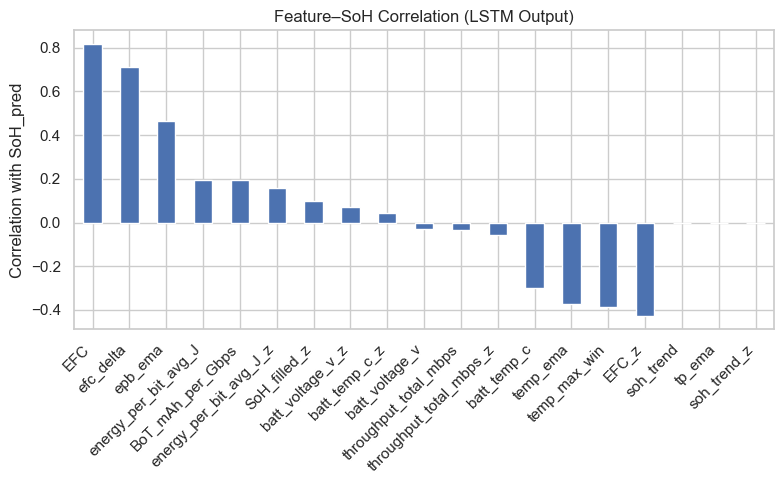

In [183]:
# SoH prediction correlation analysis
y_pred = model_soh.predict(X_test).squeeze()
y_true = y_test.squeeze()

# Flatten sequence data
N, T, F = X_test.shape
X_flat = X_test.reshape(N*T, F)

# Repeat y_true and y_pred for each time step
y_true_rep = np.repeat(y_true, T)
y_pred_rep = np.repeat(y_pred, T)

# Create dataframe for correlation analysis
df_corr = pd.DataFrame(X_flat, columns=feature_cols)
df_corr["SoH_true"] = y_true_rep
df_corr["SoH_pred"] = y_pred_rep

# Calculate Pearson correlation
corr_true = df_corr.corr()["SoH_true"].drop(["SoH_true", "SoH_pred"])
corr_pred = df_corr.corr()["SoH_pred"].drop(["SoH_true", "SoH_pred"])
corr_df = pd.DataFrame({
  "corr_with_SoH_true": corr_true,
  "corr_with_SoH_pred": corr_pred
}).sort_values("corr_with_SoH_pred", ascending=False)

print("=== Correlation Feature vs SoH ===")
print(corr_df)

# Visualize correlation with SoH_pred
plt.figure(figsize=(8, 5))
corr_df["corr_with_SoH_pred"].plot(kind="bar")
plt.ylabel("Correlation with SoH_pred")
plt.title("Feature–SoH Correlation (LSTM Output)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Baseline RMSE: 0.08157507041823042
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

=== Permutation Feature Importance (SoH) ===
                    feature  rmse_perm  delta_rmse
4                       EFC   0.137858    0.056283
10                  epb_ema   0.10209

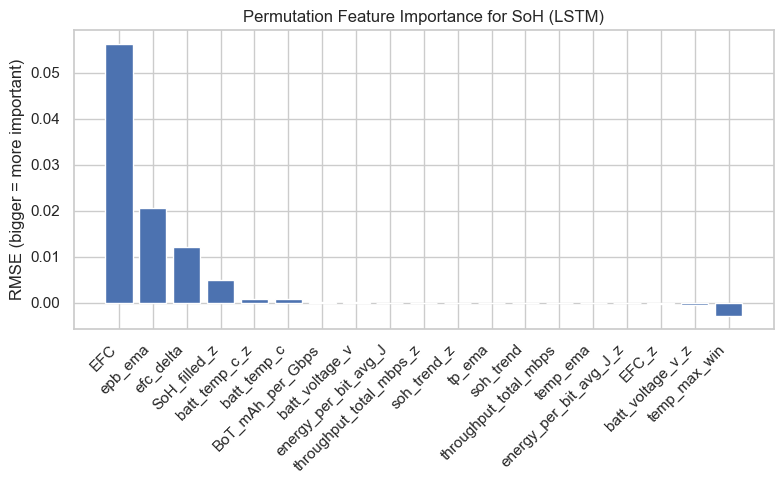

In [184]:
# Create RMSE function
def rmse(a, b):
  return np.sqrt(mean_squared_error(a, b))

# Baseline performance in test set
y_pred_base = model_soh.predict(X_test).squeeze()
y_true = y_test.squeeze()
baseline_rmse = rmse(y_true, y_pred_base)
print("Baseline RMSE:", baseline_rmse)

# Permutation Feature Importance
N, T, F = X_test.shape
importances = []

# Loop through each feature for permutation
for feat_idx, feat_name in enumerate(feature_cols):
  X_perm = X_test.copy()
  idx_perm = np.random.permutation(N)
  X_perm[:, :, feat_idx] = X_test[idx_perm, :, feat_idx]
  
  # Feature prediction with permuted feature
  y_pred_perm = model_soh.predict(X_perm).squeeze()
  rmse_perm = rmse(y_true, y_pred_perm)
  delta_rmse = rmse_perm - baseline_rmse
  importances.append({
    "feature": feat_name,
    "rmse_perm": rmse_perm,
    "delta_rmse": delta_rmse
  })

# Result in dataframe
imp_df = pd.DataFrame(importances).sort_values("delta_rmse", ascending=False)
print("\n=== Permutation Feature Importance (SoH) ===")
print(imp_df)

# Plot bar importance
plt.figure(figsize=(8, 5))
plt.bar(imp_df["feature"], imp_df["delta_rmse"])
plt.ylabel("RMSE (bigger = more important)")
plt.title("Permutation Feature Importance for SoH (LSTM)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [185]:
import os
import json
import pickle
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
export_dir = f"models/{timestamp}"
os.makedirs(export_dir, exist_ok=True)

# Save model
model_soh.save(f"{export_dir}/model.keras")

# Save scaler
with open(f"{export_dir}/scaler.pkl", "wb") as f:
  pickle.dump(scaler_X, f)

# Print if saved
print("[OK] Saved scaler.pkl")
print("Model export directory:", export_dir)

[OK] Saved scaler.pkl
Model export directory: models/20251120_184049


In [186]:
# Create config dictionary
config = {
  "window_size": 24,
  "feature_cols": feature_cols,
  "target_col": "SoH_filled",
  "scaler_type": scaler_X.__class__.__name__,
  "model_version": timestamp,
  "rul_config": {
    "strategy": "global_linear_deterministic",
    "k_global": float(k_global),
    "soh_eol": float(SoH_eol),
    "hours_per_cycle": float(h_per_cycle) if h_per_cycle is not None else None,
    "notes": "k_global ~ average SoH drop per EFC; SoH in fraction [0,1]. "
    "RUL_cycles = max((SoH_pred - soh_eol) / k_global, 0)."
  },
}

# Save config as JSON
with open(f"{export_dir}/config.json", "w") as f:
  json.dump(config, f, indent=2)
print(f"[OK] Saved config.json at {export_dir}")

# Create metdata dictionary
metadata = {
  "created_at": timestamp,
  "num_devices": df["device_id"].nunique(),
  "num_rows": len(df),
}

# Save metadata as JSON
with open(f"{export_dir}/metadata.json", "w") as f:
  json.dump(metadata, f, indent=2)
print(f"[OK] Saved metadata.json at {export_dir}")

[OK] Saved config.json at models/20251120_184049
[OK] Saved metadata.json at models/20251120_184049


In [187]:
# Update latest model
import shutil

latest = "models/latest"
if os.path.exists(latest):
  shutil.rmtree(latest)

shutil.copytree(export_dir, latest)
print(f"[OK] Updated latest model at {latest}")

[OK] Updated latest model at models/latest
